<font size=4 color='cornflowerblue'>
    
  ## Generation of samples

<font size=4>
    
 A powder x-ray diffraction pattern (XRDPP) contains the crystallographic information of a polycrystalline compound, so it is proposed that the crystal structure be inferred from the set of intensities that define an XRDPP. This notebook describes the procedure for generating the samples.
 
 There are no databases that provide the experimental XRDP, since in practice what is required is the crystalline information synthesized from the diffraction pattern, the XRDP by itself is an abstract representation of the structure. For this reason, crystallographic databases contain cif files (crystallographic information file). These files contain the relevant information of the material, including its crystalline structure. Example of a cif file can be found [here](./cif_examples/1000093.cif).
 
 The cif files have a particular structure based on a set of pairs of the form (keyword, value). 


  Since the features for the convolutional neural network are defined by the set of intensities that define an XRDP, it is required to model the XRDP from the crystallographic information contained in the cif file.

## Pymatgen

Pymatgen (Python Materials Genomics) is an open source Python library for materials analysis.

With pymatgen you can easily manipulate cif files, as well as generate crystallographic parameters from certain information in the cif file.

[Pymatgen](https://pymatgen.org/)

In [20]:
pip install pymatgen

In [21]:
pip install PyCIFRw

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pymatgen as mg
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import glob
import pandas as pd
import CifFile
import re
import shutil, os
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
import random

<font color='red'>
    
 ### 1. Create raw database

<font size=4>

#### Using the *pymatgen* library the following information is obtained:

- lattice parameters
- space group (standard symbol and number)
- crystal system

For each atom of the base the following is obtained:

- x, y, z coordinates
- Wyckoff site
- Valencia
- occupation

* Note: the occupation is not always specified, if it is not specified it is fixed as 1. *

The *create_database()* function takes the previous information and creates a dataframe with the necessary information.

In [33]:
def create_database(ruta):
    '''
    Input
    ruta: es la ruta en la que se encuentran los archivos cif
    Output
    df: es un dataframe que contiene la información de interes de cada archivo cif en ruta
    '''
    
    addrs = glob.glob(ruta)
    cif = []
    sg_number = []
    sg_symbol = []
    comp = []
    par1 = []
    par2 = []
    site = []
    system = []
    for addr in addrs:
        try:
            analyzer = SpacegroupAnalyzer(mg.Structure.from_file(addr))
            number=analyzer.get_space_group_number()
            symbol=analyzer.get_space_group_symbol()
            cs = analyzer.get_crystal_system()
            wy = str(analyzer.get_symmetrized_structure()).split('\n')
            compound = wy[2].split(' ')[-1]
            abc = list(filter(lambda x: x != "", wy[3].split(' ')))[2:]
            angles = list(filter(lambda x: x != "", wy[4].split(' ')))[1:]
            sites = []
            for i in range(len(wy)-8):
                lista = list(filter(lambda x: x != "", wy[i+8].split(' ')))[1:]
                if lista[0].find(':')<0:
                    lista[0] = lista[0] + ':1'
                sites.append(lista)
            cif.append(addr.split('.')[0].split('/')[-1])
            sg_number.append(number)
            sg_symbol.append(symbol)
            system.append(cs)
            comp.append(compound)
            par1.append(abc)
            par2.append(angles)
            site.append(sites)
        except:
            pass
    
    df = pd.DataFrame({'cif': cif, 'compound': comp, 
                       'cs': system, 'sg_number': sg_number, 'sg_symbol': sg_symbol, 
                       'abc': par1, 'angles': par2, 'sites': site})
    #df.drop_duplicates()
    return df

In [34]:
df_raw = create_database('/content/drive/MyDrive/TSFCIII-2021-1/Clase 11/cif_examples/*.cif')

In [35]:
df_raw

,cif,compound,cs,sg_number,sg_symbol,abc,angles,sites


In [28]:
df_raw.shape

(0, 8)

In [29]:
cifs_raw = df_raw['cif']

In [30]:
cifs_raw.shape

(0,)

<font color='red'>
    
 ### 2. Modeling XRDP with TOPAS

<font size=4>

To model the XRDP, we start from the crystallographic information contained in the cif and use the TOPAS software.

**The template calculates 15 diffraction patterns **

- 5 different crystal sizes: 200, 400, 600, 800, 1000 nm, and

- For each crystal size, three displacements of the sample from the diffraction plane are considered -0.01, 0.0 and 0.01.

These two variables cover typical variations in the diffraction pattern.  

**The *create_input ()* function takes the information from the previously created dataframe and puts it in the proper syntax to create an .inp file that is the input to TOPAS.**

In [15]:
def create_input(df, sample):
    
    '''
    Para cada muestra en el df se crea un archivo input de TOPAS.
    Esta función se debe ejecutar simultaneamente con TOPAS, 
    pues cada archivo .inp se sobreescribe por cada muestra.
    
    Input----> sample: muestra de un df (df.iloc[i])
    Output----> file.inp: archivo de entrada a TOPAS'''   
    
    try:  
        os.stat('samples') 
    except: 
        os.mkdir('samples')  
                
    if os.path.exists('samples\input_file.inp'):    
        file = open("samples\input_file.inp","r+")
        file.truncate(0)
        file.close()
    input_file = open('samples\\input_file.inp', 'w')
    
    numcif = df.iloc[sample]['cif']
    formula = df.iloc[sample]['compound']
    sg = df.iloc[sample]['sg_symbol'] 
    a = df.iloc[sample]['abc'][0]
    b = df.iloc[sample]['abc'][1]
    c = df.iloc[sample]['abc'][2]
    alpha = df.iloc[sample]['angles'][0]
    beta = df.iloc[sample]['angles'][1]
    gamma = df.iloc[sample]['angles'][2]  
    print(numcif, '\n')
    input_file.write(
                'iters 0' + '\n' + '\n' +
                'num_runs 15' + '\n' + '\n' + 
                "'Varying average crystallite size 200, 400, 600, 800 y 1000 nm" + '\n' +
                "'Varying specimen displacement -0.01. 0.0, 0.01" + '\n' +
                'File_Variables(aver_size_0, 200, 1000, 200, sp_d, -0.01, 0.01, 0.01)' + '\n' + '\n' + 
                'yobs_eqn = 1;' + '\n' +
                '   min 2.0' + '\n' + 
                '   max 135.0' + '\n' + 
                '   del 0.01' + '\n' + '\n' +
                'Out_X_Ycalc( ' + numcif + '-##Run_Number##.xy)' + '\n' + '\n' +
                'bkg 0 0 0 0' + '\n' + '\n' +
                'prm !spec_disp = #out sp_d ;' + '\n' + '\n' +
                'Specimen_Displacement (spec_disp)' + '\n' + '\n' +    
                'str' + '\n' + 
                'scale 0.01' + '\n' +
                'phase_name ' + formula + '\n' +
                'space_group ' + sg + '\n' +
                'a ' + str(a) + '\n' +
                'b ' + str(b) + '\n' +
                'c ' + str(c) + '\n' +
                'al ' + str(alpha) + '\n' +
                'be ' + str(beta) + '\n' + 
                'ga ' + str(gamma) + '\n')

    num = '0123456789'
    sites = df.iloc[sample]['sites']
    for site in sites: 
        if all(map(str.isdigit, site[-1].replace('.', ''))):
            site = site[:-1]
        if len(site)==5:
            # site=[atom:occ, x, y, z, wyckoff]
            x = site[1]
            y = site[2]
            z = site[3]
            occ = site[0].split(':')[-1]
            multiplicity = site[4][:-1]
            
            atom = site[0].split(':')[0]
            atom =  re.sub(r'[0-9]+', '', atom).replace('.', '').replace('+', '').replace('-', '')
           
            input_file.write('site ' + atom + ' x ' + x + ' y '  + y + ' z ' + z + 
                  ' occ '  + atom + ' ' + occ + ' beq 0.5' + '\n')
            
        else:  
            # site=[atom_1:occ_1, ..., atom_n:occ_n, x, y, z, wyckoff]
            x = site[-4]
            y = site[-3]
            z = site[-2]
            multiplicity = site[-1][:-1]
            
            k = site[:-4]
            # k=[atom_1:occ_1, ..., atom_n:occ_n]
            for i in k:
                occ = i.split(':')[-1].replace(',', '')
                atom = i.split(':')[0]
                atom =  re.sub(r'[0-9]+', '', atom).replace('.', '').replace('+', '').replace('-', '')
                
                input_file.write('site ' + atom + ' x ' + x + ' y '  + y + ' z ' + z + 
                      ' occ '  + atom + ' ' + occ + ' beq 0.5' + '\n')
    input_file.write(
                '\n' +
                
                'prm !aver_size  = #out aver_size_0 ;' + '\n' + '\n' +
                "lor_fwhm = 0.1 57.295779 * Lam /(Cos(Th)*aver_size) ;  'in nanometers" + '\n' + '\n' +
                ' prm  !strain 0.0001' + '\n' +
                '      gauss_fwhm = strain Tan(Th) ;' + '\n' + '\n' +
                   #"'X-ray Source Cu anode, Hoelzer(Phys. Rev. A 6, 4554 (1997)" + '\n' + 
                    'lam'  + '\n' + 
                    'ymin_on_ymax 0.00001' + '\n' +
                    '        la  0.579  lo  1.5405902 lh  0.4374157' + '\n' +
                    '        la  0.080  lo  1.5410632 lh  0.6432140' + '\n' +
                    '        la  0.236  lo  1.5443983 lh  0.5128764' + '\n' +
                    '        la  0.105  lo  1.5446848 lh  0.6872322' + '\n' +
                    '        la  0.0016 lo  1.3922   lh  0.55' + '\n' + '\n' +                                        
                    '        Radius(217.5)' + '\n' + '\n' +
                #"' Lorentz Polarization corrections. No monochromator; then th2_monochromator = 0" + '\n' +
                'LP_Factor(!th2_monochromator, 0)'+ '\n' + '\n' +
                #"'Full axial divergence model from Coehlo TOPAS V 6" + '\n' +
                'Full_Axial_Model(12, 15, 16, 2.55, 3.10)'+ '\n' + '\n' +
                '/*' + '\n' +
                #"'Full axial divergence model from Coehlo TOPAS V 4" + '\n' +
                'filament_length               12' + '\n' +
                'sample_length                 15' + '\n' +
                "receiving_slit_length         16   'this is the detector slit" + '\n' +
                'primary_soller_angle       2.55' + '\n' +
                '    secondary_soller_angle   3.10' + '\n'  + '\n' +
                ' Divergence(, 0.5)' + '\n' +
                "    Slit_Width(, 0.075)         'This is the detector slit" + '\n' +
                '*/' + '\n'  + '\n' +
                #"'This is the macro Tube_Tails" + '\n' +
                'prm !b1  0.00381' + '\n' +
                'prm !c1  -0.9278' + '\n' +
                'prm !d1  1.94324' + '\n' +
                'prm !e1  0.00007' + '\n' + '\n' +
                '  stacked_hats_conv' + '\n' +
                '  whole_hat  = b1 57.2957795130823 / Rs;' + '\n' +
                '  half_hat   = c1 57.2957795130823 / Rs ;' + '\n' +
                '  hat_height = e1 ;' + '\n' +
                '  half_hat   = d1 57.2957795130823 / Rs ;' + '\n' +
                '  hat_height = e1 ;' + '\n' #+
                #"'End of the macro Tube_Tails"
    )
              
    return

La siguiente celda no funcionara para ustedes porque se usa el software TOPAS, despues de ejecutar la siguiente celda se genera una carpeta llamada samples, la cual contiene a los patrones modelados, ustedes ya tienen esa carpeta dentro del material de esta clase. 

In [16]:
for sample in range(len(df_raw)):
    create_input(df_raw, sample)
    !C:\Topas-6\tc C:\Users\Larec_4\Desktop\generacion-de-muestras-vf\samples\input_file.inp
            
    #print('\n')

In [17]:
xy_files=glob.glob('/content/drive/MyDrive/TSFCIII-2021-1/Clase 11/samples/*.xy')
len(xy_files)

0

<font size=4>

**The next cell extracts the intensity column for each .xy file created**

In [18]:
df_list = list()
xs = []
xy_name = []
for numcif in list(cifs_raw):
    try:
        for i in range(15):
            if os.stat('/content/drive/MyDrive/TSFCIII-2021-1/Clase 11/samples/' + str(numcif) + '-' + str(i) + '.xy'):
                df_x = pd.read_csv('/content/drive/MyDrive/TSFCIII-2021-1/Clase 11/samples/' + str(numcif) + '-' + str(i) + '.xy', sep='   ', header = None)
                xs.append(np.array(df_x.iloc[:, 1]))
                df_list.append(df_raw.loc[df_raw['cif'] == str(numcif)])
                xy_name.append(str(numcif))
    except:
        print(numcif)
         #pass

<font size=4>

**We create a dataframe with the data that was used to model the XRDP**

In [19]:
df = pd.DataFrame()
df = df.append(df_list)
df['xy_name'] = xy_name
cif = df['cif']
compound = df['compound']
systems = df['cs']
sg_num = df['sg_number']
df.shape

KeyError: ignored

In [ ]:
df.shape

(90, 9)

In [ ]:
df.head(20)

,cif,compound,cs,sg_number,sg_symbol,abc,angles,sites,xy_name
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271
0,1001271,Na1.5P4W8O32,monoclinic,14,P2_1/c,"[17.788000, 5.277000, 6.607000]","[90.000000, 99.640000, 90.000000]","[[Na+:0.375, 0.008, 0.225, 0.139, 4e], [P5+:1,...",1001271


<font color='red'>

### 3. Rescaling x data



<font size=4>

Rescale the data, so that each XRDP has intensities between 0 and 100. This rescaling is done for each XRDP.

In [ ]:
def rescaling_xrdp(x):
    
    '''
    Reescala cada XRDP.
    Arguments
    x: list with entry arrays of shape (features, )
    Return
    resc_x: list with entry arrays of shape (features, ) reescaled
    '''
    x_rescale = []
    
    for sample in x:
        sample = np.nan_to_num(sample)
        max_intensity = np.max(sample)
        resc_x = (sample/max_intensity)*100
        x_rescale.append(resc_x)
    
    return x_rescale

In [ ]:
x_rescale = rescaling_xrdp(xs)

<font size=4>
    
#### Comparison between XRDP and rescale XRDP

In [ ]:
theta_2 = [5]
j = 5
for i in range(13300):
    j += 0.01
    theta_2.append(np.round(j, 2))

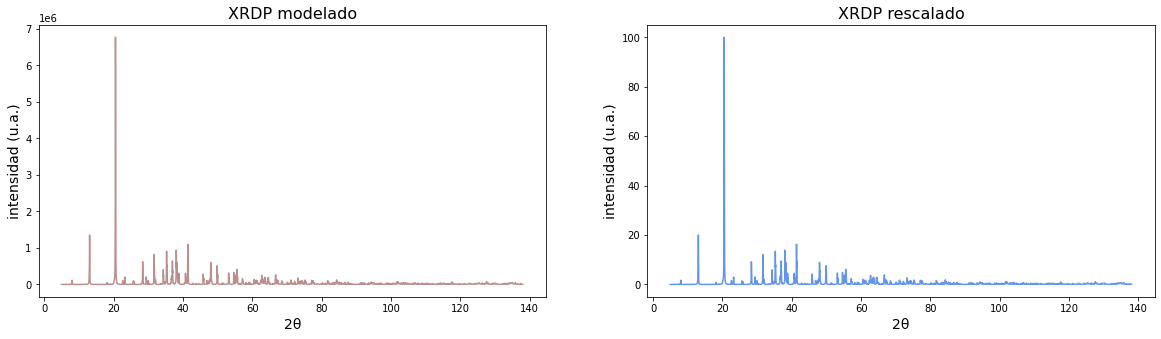

In [ ]:
plt.figure(figsize=(20, 5))
i=1
ax = plt.subplot(1, 2,1)
plt.plot(theta_2, xs[i], color='rosybrown');
#plt.grid("on")
plt.title('XRDP modelado', size=16)
plt.ylabel('intensidad (u.a.)', size=14)
plt.xlabel('2θ', size=14)
ax = plt.subplot(1, 2, 2)
plt.plot(theta_2, x_rescale[i], color='cornflowerblue');
#plt.grid("on")
plt.title('XRDP rescalado', size=16)
plt.ylabel('intensidad (u.a.)', size=14)
plt.xlabel('2θ', size=14);

<font color='red'>
    
 ### 4. Saving data in h5 file

<font size=4>

The data required for CNN: normalized intensities, space group, crystalline system, as well as the cif are saved in a .h5 file

In [ ]:
data = [cif, compound, x_rescale, systems, sg_num]

In [ ]:
def to_h5(data, file_name):
    
    '''
    Esta función crea el archivo h5 que contendra a los datos 
    modelados X y su grupo espacial, así como el cif para futuras referencias.
    Input:
    data: contiene los datos de la red: (cif, x, cs, sg_num)
    file_name: es el nombre a asignar al .h5
    '''

    id_cif = data[0].astype('S7')
    compound = data[1].astype('S100')
    x = np.array(data[2])
    cs = data[3].astype('S12')
    sg = np.array(data[4])
    
    if not os.path.exists(file_name):
        f = h5py.File(file_name, 'w')
        f.create_dataset('cif', data = id_cif, chunks=True, maxshape=(None,))
        f.create_dataset('compound', data = compound, chunks=True, maxshape=(None,))
        f.create_dataset('x', data = x, chunks=True, maxshape=(None, 13301))
        f.create_dataset('cs', data = cs, chunks=True, maxshape=(None,))
        f.create_dataset('sg', data = sg, chunks=True, maxshape=(None,))
        print(f.keys())
        f.close()

    else:
        f = h5py.File(file_name, 'a')
        f['cif'].resize((f['cif'].shape[0] + id_cif.shape[0]), axis = 0)
        f['cif'][-id_cif.shape[0]:] = id_cif
        f['compound'].resize((f['compound'].shape[0] + compound.shape[0]), axis = 0)
        f['compound'][-compound.shape[0]:] = compound
        f['x'].resize((f['x'].shape[0] + x.shape[0]), axis = 0)
        f['x'][-x.shape[0]:] = x
        f['cs'].resize((f['cs'].shape[0] + cs.shape[0]), axis = 0)
        f['cs'][-id_cif.shape[0]:] = cs
        f['sg'].resize((f['sg'].shape[0] + sg.shape[0]), axis = 0)
        f['sg'][-sg.shape[0]:] = sg
        print(f.keys())
        f.close() 

In [ ]:
to_h5(data, 'prueba.h5')

<KeysViewHDF5 ['cif', 'compound', 'cs', 'sg', 'x']>


<font size=4>

#### Viewing one sample

In [ ]:
f = h5py.File('prueba.h5', 'r')
cif = f['cif'][:]
compound = f['compound'][:]
x = f['x'][:]
cs = f['cs'][:]
sg = f['sg'][:]
f.close()

In [ ]:
sg.shape

(90,)

muestra: 1 
 cif: b'1001271' 
 compound: b'Na1.5P4W8O32' 
 sistema cristalino: b'monoclinic' 
 grupo espacial: 14 



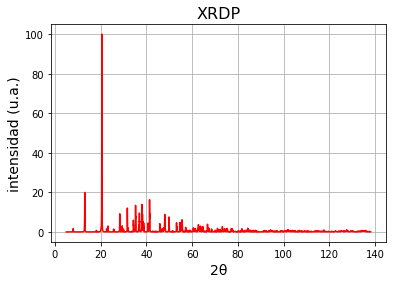

In [ ]:
sample = 1
print('muestra:', sample, '\n',
      'cif:', cif[sample], '\n',
      'compound:', compound[sample], '\n',
      'sistema cristalino:', cs[sample], '\n',
      'grupo espacial:', sg[sample], '\n')
plt.plot(theta_2, x[sample], color='red')
plt.grid("on")
plt.title('XRDP', size=16)
plt.ylabel('intensidad (u.a.)', size=14)
plt.xlabel('2θ', size=14);